In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import date
import re

# Check main directory
maindir = "./f5"
yeardirs = [x for x in os.listdir(maindir) if os.path.isdir(os.path.join(maindir, x))]  # List of annual directories
yeardirs = np.sort(yeardirs)

# Set up blank arrays
ndates = (date.today()-date(int(yeardirs[0]), 1, 1)).days
fulldates = pd.date_range(date(int(yeardirs[0]), 1, 1), date.today())

stanames = [] # To hold unique station names
allyeardirs = [] # To hold repeated year directory names
allposfiles = [] # To hold .pos filenames

# Loops through years
for i in range(len(yeardirs)):
# Get list of .pos files
    posfiles = [x for x in os.listdir(os.path.join(maindir, yeardirs[i])) if (x[-3:] == "pos")]
    allyeardirs = allyeardirs + [yeardirs[i]]*len(posfiles)
    allposfiles = allposfiles + posfiles
    # Extract station names from .pos filenames
    staname = [x[0:-7] for x in posfiles]
    stanames = list(set(stanames + staname))
    stanames.sort()

nsta = len(stanames)
# Blank position arrays
X = np.zeros([nsta, ndates+1])
Y = np.zeros([nsta, ndates+1])
Z = np.zeros([nsta, ndates+1])
lat = np.zeros([nsta, ndates+1])
lon = np.zeros([nsta, ndates+1])
hgt = np.zeros([nsta, ndates+1])


# Read in each .pos file
for i in range(len(allposfiles)):
    df = pd.read_csv(
        os.path.join(maindir, allyeardirs[i], allposfiles[i]),
        skiprows=20,
        skipfooter=2,
        engine='python',
        sep="\s+",
        names=["year", "month", "day", "t", "x", "y", "z", "lat", "lon", "hgt"],
    )
    # Assemble date columns into datetime
    df["date"] = pd.to_datetime(df[['year','month','day']])

    # Insert positions into proper row, column
    rowid = stanames.index(allposfiles[i][0:-7]) # Row index
    colid = np.flatnonzero(np.in1d(fulldates, df.date) & np.in1d(fulldates, df.date)) # Column indices
    X[rowid, colid] = df.x
    Y[rowid, colid] = df.y
    Z[rowid, colid] = df.z
    lon[rowid, colid] = df.lon
    lat[rowid, colid] = df.lat
    hgt[rowid, colid] = df.hgt

# Calculate reference lon, lat for ENU conversion
lonmean = np.sum(lon, axis=1)/np.sum(lon !=0, axis=1)
latmean = np.sum(lat, axis=1)/np.sum(lat !=0, axis=1)

# Convert names to np array of strings
stanames = np.array(stanames)

## Trim arrays

In [2]:
# Trim any blank columns
xsum = np.sum(X, axis=0)
keepcols = xsum != 0
X = X[:, keepcols]
Y = Y[:, keepcols]
Z = Z[:, keepcols]
lon = lon[:, keepcols] 
lat = lat[:, keepcols]
hgt = hgt[:, keepcols]
fulldates = fulldates[keepcols]
# As numpy array. Needed to save in HDF5
dates = np.array(fulldates)
dates = np.array(dates, dtype='datetime64[D]') # Without times

## Make offset array

In [3]:
def sph_distance(point1, point2):
    R = 6370
    lat1 = np.radians(point1[0])  #insert value
    lon1 = np.radians(point1[1])
    lat2 = np.radians(point2[0])
    lon2 = np.radians(point2[1])

    dlon = lon2 - lon1
    dlat = lat2- lat1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = R * c
    return distance

# Make offset matrix
- `nSta-by-nDays` 
- Includes equipment maintenance
- Includes earthquakes from CMT search ($M_W\geq6.0$, $z < 100$ km)
- Earthquakes are deemed to cause an offset if a station lies within $10^{0.36M_W - 0.15}$ km of the epicenter

In [4]:
from scipy.spatial.distance import cdist

# Load offsets 
offsets = pd.read_excel('f5/F3_offset_var221231.xlsx', 'Maintenance_list')
# Get rid of unparseable characters
offsets = offsets[offsets.month != "?"]
# Assemble date columns into datetime
offsets["date"] = pd.to_datetime(offsets[['year','month','day']])
# Reset index
offsets.reset_index(inplace=True, drop=True)

# Allocate space
offs = np.zeros_like(X, dtype=bool)
# For each offset, 

for i in range(len(offsets)):
    siteidx = np.where(stanames == str(offsets.loc[i, "site"])) # Station index
    dateidx = np.where(dates == offsets.loc[i, "date"]) # Date index
    offs[siteidx, dateidx] = True # Set to True on day of offset

# Load earthquakes 
eq = pd.read_csv("japan_cmt_1996-2023_m6_d100.psvelomeca", sep="\s+")
# Calculate moment and moment magnitude
eq["mom"] = eq.sc*np.power(10, eq.iexp, dtype=np.float64)
eq["mag"] = (2/3)*(np.log10(eq.mom)-16.1)
# Distance threshold exponent
threshexp = np.array(0.36*eq.mag - 0.15)
threshdist = np.power(10, threshexp)
threshdist = np.repeat(threshdist, len(lonmean)).reshape(len(eq), len(lonmean)).T

# Distance between stations and earthquakes
eq_points = eq[["lat", "lon"]].values
sta_points = np.array([latmean, lonmean]).T
sta_eq_dist = cdist(sta_points, eq_points, sph_distance)
# Logical array indicating if there should be an earthquake jump
eqjump = np.less(sta_eq_dist, threshdist)
# Insert at correct dates
eqjumpdates = np.zeros_like(X, dtype=bool)

for i in range(len(eq)):
    # Parse dates from event name
    eqname = eq.loc[i, "name"]
    if len(eqname) == 13:
        eqdate = datetime.strptime(eqname[0:8], '%Y%m%d')
    else:
        eqdate = datetime.strptime(eqname[0:6], '%m%d%y')

    dateidx = np.where(dates == np.array(eqdate, dtype='datetime64[D]'))[0] # Date index
    if len(dateidx) != 0:
        eqjumpdates[:, dateidx[0]] = eqjumpdates[:, dateidx[0]] + eqjump[:, i]

# Combine earthquakes with maintenance 
offs = offs + eqjumpdates
# Cumulative sum  
offs = np.cumsum(offs, axis=1)


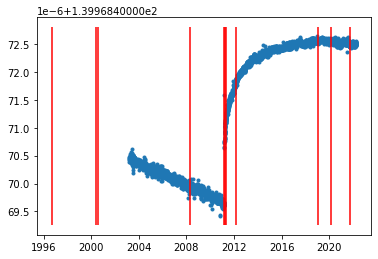

In [5]:
# Sample plot 
staidx = 120

from matplotlib import pyplot as plt
fig, ax = plt.subplots() # Set up the axes
ax.plot(fulldates[lon[staidx, :] != 0], lon[staidx, lon[staidx, :] != 0], '.') # Place time vs. position in those axes for specified station
theseoffs = np.where(np.diff(offs[staidx, :]) != 0)
thesedates = dates[theseoffs]
yl = ax.get_ylim()
ax.vlines(thesedates, yl[0], yl[1], color='r')
plt.show()



## Write data

In [17]:
import h5py

# Write to HDF5 file
hf = h5py.File("geonet_f5.h5", "w")
hf["X"] = X
hf["Y"] = Y
hf["Z"] = Z
hf["lon"] = lon
hf["lat"] = lat
hf["hgt"] = hgt
hf["date"] = dates.astype(h5py.opaque_dtype(dates.dtype))
hf["name"] = stanames.astype(object)
hf["offsets"] = offs
hf.close()

## Test read data

In [18]:
# Load data
hf = h5py.File('geonet_f5.h5', 'r')
X = np.array(hf["X"])
Y = np.array(hf["Y"])
Z = np.array(hf["Z"])
lon = np.array(hf["lon"])
lat = np.array(hf["lat"])
hgt = np.array(hf["hgt"])
date = np.array(hf["date"]) # These include times
date = np.array(date, dtype='datetime64[D]') # Without times
name = hf["name"].asstr()[:] # Makes a numpy array of strings
offs = np.array(hf["offsets"])
# Calculate reference lon, lat for ENU conversion
lonmean = np.sum(lon, axis=1)/np.sum(lon !=0, axis=1)
latmean = np.sum(lat, axis=1)/np.sum(lat !=0, axis=1)